In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statistics import mean, stdev
from dask import compute, delayed
import dask.multiprocessing
import multiprocessing
import timeit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.model_selection  import KFold

import warnings
warnings.filterwarnings("ignore")

Problem 1

a.

In [2]:
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

Shape of bq_data (78, 7)
Bequest distribution by income group: [0.01214584 0.00817072 0.01590964 0.0139963  0.01383075 0.06927237
 0.86667437]
Bequest distribution by age group: [8.86582658e-04 5.70017321e-04 1.22808428e-02 6.89456419e-04
 2.13752835e-04 3.07249416e-03 2.15844659e-03 1.14127672e-03
 9.77767430e-03 1.25006312e-02 7.32933120e-03 8.90001319e-03
 4.36423812e-03 8.79963316e-03 5.31438054e-03 7.46667436e-03
 9.86805613e-03 1.24892682e-02 4.88834783e-03 5.27214505e-03
 3.58273277e-02 1.16728805e-02 1.02956537e-02 1.09182048e-02
 2.34851553e-02 1.87283522e-02 3.93666749e-02 1.87449101e-02
 4.88500163e-02 1.59935003e-02 2.43528902e-02 2.56744256e-02
 1.56556262e-02 5.09342207e-02 2.04055385e-02 1.57812659e-02
 4.72762613e-02 1.76250983e-02 2.83611980e-02 1.34761987e-02
 6.12574170e-02 2.41355622e-02 1.98039177e-02 2.21873164e-02
 3.56284346e-02 4.49420967e-02 1.14887709e-02 2.83048159e-02
 8.92448997e-03 1.13632467e-02 1.59677078e-02 1.39055369e-02
 6.78948218e-03 1.92259141e-0

Text(0.5, 0, 'Percent of BQ received')

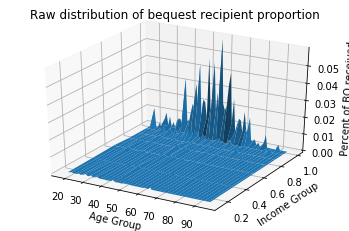

In [3]:
# Some diagnostics
print('Shape of bq_data', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0))
print('Bequest distribution by age group:',
      bq_data.sum(axis=1))
print('Sum of all probabilities', bq_data.sum())


BQ_mat_raw = bq_data / bq_data.sum()
# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection ='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat_raw)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age Group')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

b.

Text(0.5, 0, 'Percent of BQ received')

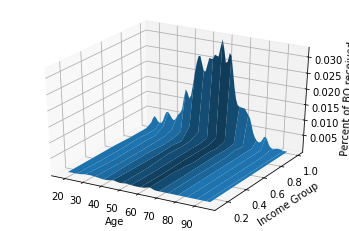

In [6]:
bq_df = pd.DataFrame(bq_data)
bq_df.index = age_vec
bq_df.columns = lambdas_mdpts
df = pd.DataFrame()
for row in bq_df.index:
    for col in bq_df.columns:
        df = df.append([[row, col, bq_df.loc[row][col]]])
df.index = np.arange(0, 546)
df.columns = ['age', 'group', 'prob']
df_s = pd.DataFrame()
index = np.random.choice(546, 10000, p = df['prob'])
df_s = df.iloc[index][['age', 'group']]

bandwidth = 0.1
kernel = gaussian_kde(df_s.T, bw_method = bandwidth)
z_vec = np.reshape(kernel(np.vstack([item.ravel() for item in [age_mat, income_mat]])), age_mat.shape)
z_scaled = z_vec / float(np.sum(z_vec))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, z_scaled, rstride=5)
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

In [7]:
bws = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bws}, cv= KFold(10))
grid.fit(bq_data[:, ])
print("Cross validation proves that", grid.best_params_["bandwidth"], "fits best and offers a smooth surface that fits the data")

Cross validation proves that 0.1 fits best and offers a smooth surface that fits the data


In [8]:
print("The stimated density for bequest recipients who are age 61 in the 6th lifetime income category =", z_scaled[43,5], ".")
print("While the real density =", bq_data[43,5], ".")

The stimated density for bequest recipients who are age 61 in the 6th lifetime income category = 0.0010408838334705834 .
While the real density = 0.0008630400696026425 .


Problem 2

a

In [10]:
df = pd.read_csv('Auto.csv',na_values = "?")
df.dropna(inplace=True)

df['orgn1'] = 0
df.orgn1[df['origin']==1] = 1
df['orgn2'] = 0
df.orgn2[df['origin']==2] = 1

median = df['mpg'].median()
df['mpg_high'] = 0
df.mpg_high[df['mpg']>=median] = 1

y = df['mpg_high'].values
X = df[['cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'orgn1', 'orgn2']].values

t_start = timeit.default_timer()
mse = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=i+100)
    LogReg = LogisticRegression(n_jobs=1)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    mse_now = ((y_test - y_pred) ** 2).mean()
    mse.append(mse_now)
print('The average error rate =', mean(mse))
print('The computation time =',timeit.default_timer() - t_start,'seconds')

The average error rate = 0.10231884057971015
The computation time = 0.15017652500000622 seconds


b.

In [11]:
# Check number of cores. 
num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

def mse_value(bootstrap, seed, dt):
    X, y = dt
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=seed)
    LR = LogisticRegression(solver='lbfgs', max_iter=2000, n_jobs=1)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    mse_now = ((y_test - y_pred) ** 2).mean()
    return mse_now

t_start2 = timeit.default_timer()
mse_p = []
for i in range(100):
    mse_p.append(delayed(mse_value)(i+1, i+1, [X,y]))
mse_avg = np.array(compute(*mse_p, scheduler=dask.multiprocessing.get, num_workers=num_cores)).mean()
print('The average error rate =', mse_avg)
print('The computation time =',timeit.default_timer() - t_start2,'seconds')

Number of available cores is 4
The average error rate = 0.10173913043478258
The computation time = 12.837669080000012 seconds
